In [28]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import get_data, get_dir
import numpy as np
import PcmPy as pcm
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sb
import scipy.stats as stats
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th

#%matplotlib widget
#%matplotlib qt
%matplotlib inline

fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 12

save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'

In [7]:
folder_name = 'Sim_all_128'
num_hidden = 128

seed = 100

ff_coef = [0,8,0,8]
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['NF1','FF1','NF2','FF2']

T = pd.DataFrame()

N_idx = 16 # 16
F_idx = 25 # 25

rdms = []
for mn in range(0,20):
    model_name = "model{:02d}".format(mn)

    # 0. load muscle space
    n_muscle = 6
    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    _, _, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle] # output potent:  neurons x n_muscle
    #N = V[:,n_muscle:].T # output null space: ...x neurons

    # 1. Estimating TDR axes
    # U2 = get_data(folder_name,model_name,{'NF1':[0]},[0]
    #               ,batch_size=400,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed) # ,batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed
    
    # N = np.array(U2[0]['all_hidden'])[:,N_idx,:]
    # X = np.array(U2[0]['endpoint_force'])[:,F_idx,:]
    # tdr0 = build_tdr(X,N)

    # 1. Load data
    U = get_data(folder_name,model_name,phase,ff_coef,num_hidden=num_hidden) # ,batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed
    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])
    
    # 1.1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)
    
    # 2.1 projection onto TDR
    data_p = project_onto_map(data,tdr,remove_mean=True)
    
    # RDM
    D = np.stack(data_p)
    dims = D.shape
    D = D.reshape(dims[0],-1)
    rdms.append(pdist(D))

    # 2.2 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    #us_orth_norm = orth_wrt_map(us,tdr) 
    us_orth_norm = orth_wrt_map(us,P) # hear i want to try something different -P.mean(axis=0)

    proj_onto_us = project_onto_map(data,us_orth_norm,remove_mean=True,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()

    d = {
    'mn': [mn] * len(labels),  # Repeat mn for the length of labels
    'phase': labels,  # Use labels directly
    'us': u_mean.tolist()  # Convert u_mean Series to list
    }

    T = pd.concat([T, pd.DataFrame(d)], ignore_index=True)

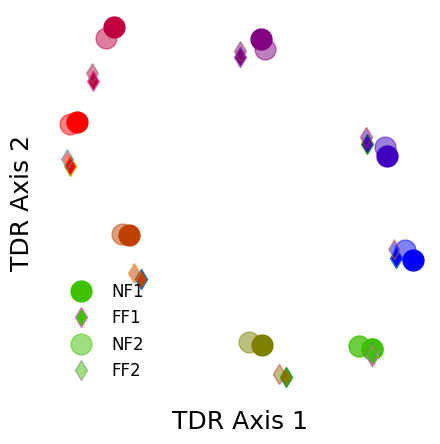

<Figure size 640x480 with 0 Axes>

In [29]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]
n_cond = len(angle_set)

# Create a scatter plot

fig,ax = plt.subplots(1,1,figsize=(5,5))

plt.figure()
for i in range(n_cond):
    ax.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i])
    ax.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i])
    ax.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5)
    ax.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5)
    if i == n_cond-1:
        ax.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i],label='NF1')
        ax.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i],label='FF1')
        ax.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5,label='NF2')
        ax.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5,label='FF2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_aspect('equal')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left = False,bottom = False) 
ax.set_xlabel('TDR Axis 1', fontsize = fontsize_label)
ax.set_ylabel('TDR Axis 2', fontsize = fontsize_label)

ax.legend(loc='lower left', fontsize=fontsize_legend,frameon=False)
# plt.xlabel('TDR Axis 1')
# plt.ylabel('TDR Axis 2')
# plt.title('Neural States in TDR Subspace')

#fig.savefig(os.path.join(save_fig,'tdr.pdf'),dpi=300,bbox_inches='tight')

# Better visualization

T-statistic: -6.602184974040252
P-value: 2.559900738002539e-06


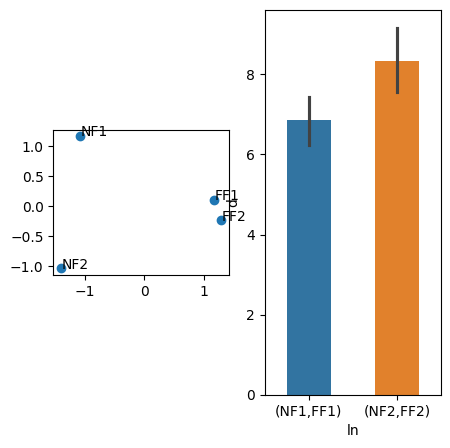

In [34]:
# 1 . MDS

rdm_avg = np.mean(np.stack(rdms,axis=0),axis=0)
rdm_m = squareform(rdm_avg)

n_cond = rdm_m.shape[0]

H = np.eye(n_cond) - np.ones((n_cond,n_cond))/n_cond
G = -0.5*H@rdm_m@H

W,Glam = pcm.classical_mds(G)


# 2 . Distance
select = [0,5]
label = []
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        pair = f'({labels[i]},{labels[j]})'
        label.append(pair)

L = pd.DataFrame()
for i in range(len(rdms)):
    for j in select:
        d = {'m':[i],'ln':[label[j]],'d':[rdms[i][j]]}
        L = pd.concat([L,pd.DataFrame(d)],ignore_index=True)



# FIGURE
fig,ax = plt.subplots(1,2,figsize=(5,5))

# Axis 1
ax[0].scatter(W[:,0],W[:,1])
ax[0].set_aspect('equal')

for i, label in enumerate(labels):
    ax[0].annotate(label, (W[i,0],W[i,1]))

# Axis 2
ax[1] = sb.barplot(x='ln',y='d',data=L,hue='ln',width=0.5)



# TTEST
sample1 = L.d[L.ln == '(NF1,FF1)'].to_numpy()
sample2 = L.d[L.ln == '(NF2,FF2)'].to_numpy()
sample3 = L.d[L.ln == '(NF2,FF2-)'].to_numpy()

t_statistic, p_value = stats.ttest_rel(sample1, sample2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

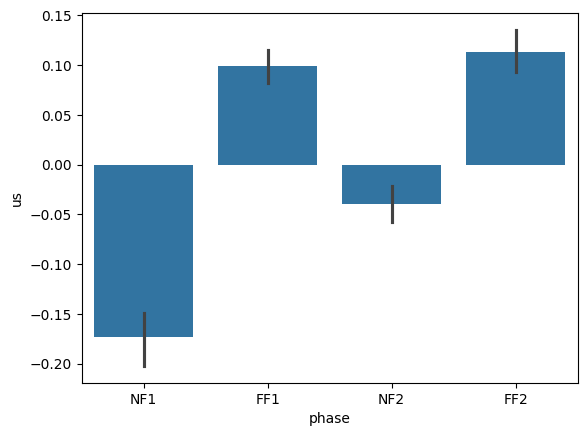

In [39]:
# Assuming T is your DataFrame
sb.barplot(x='phase', y='us', data=T)
plt.show()

In [22]:
sample1 = T.us[T.phase == 'NF1'].to_numpy()
sample2 = T.us[T.phase == 'FF1'].to_numpy()
sample3 = T.us[T.phase == 'NF2'].to_numpy()
sample4 = T.us[T.phase == 'FF2'].to_numpy()
sample5 = T.us[T.phase == 'FF2-'].to_numpy()


# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample1, sample3)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -7.417683483206661
P-value: 5.053578273387263e-07


In [57]:
# relate behavior to neural activity

# the amount of saving to the difference between sample3 and sample1
sample2


array([ 0.26858269,  0.5343854 ,  0.26686265,  1.13637544,  0.12584814,
       -0.01031572,  0.42600612,  0.49679087,  0.93068292,  0.53317735,
        0.48111239,  0.68589445,  0.99650188,  0.94516639,  0.52517623,
        0.85397428,  0.38352492,  0.34586975,  0.99924104,  0.57848838])

In [58]:
saving_neural = sample3-sample1
stats.ttest_1samp(saving_neural,0)

array([ 0.09189627,  0.063627  ,  0.02558091,  0.19424682,  0.07208311,
        0.05673796,  0.17383491,  0.18028929,  0.04968159,  0.0037039 ,
        0.16573672,  0.0641676 , -0.03193862,  0.11884163,  0.0398113 ,
        0.0484426 ,  0.08369762,  0.11318683,  0.0140046 ,  0.00782773])

In [5]:
import numpy as np
from plot import window_average
import json


phases = {'FF1':[8],'FF2':[8]}
num_model = 20
loss_type = 'position'
folder_name = 'Sim_all'

w = 1

all_phase = list(phases.keys())

# load behavior and start fitting
loss = {phase: [] for phase in phases.keys()}
for i,phase in enumerate(phases.keys()):
    for m in range(num_model):
        model_name = "model{:02d}".format(m)
        _,_,log=get_dir(folder_name, model_name, phase, phases[phase][0])
        log = json.load(open(log,'r'))
        loss[phase].append(log[loss_type])

    # Calculate window averages for all models
    loss[phase] = [window_average(np.array(l), w) for l in loss[phase]]

saving_behav = np.array(loss['FF1'])[:,0] - np.array(loss['FF2'])[:,0]
stats.ttest_1samp(saving_behav,0)

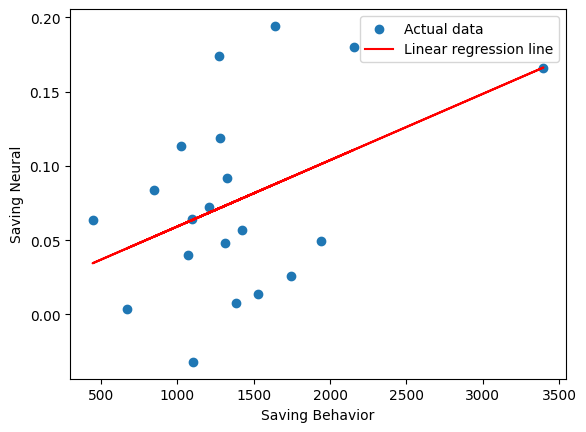

In [65]:
from sklearn.linear_model import LinearRegression

# Reshape the data if needed
saving_behav = saving_behav.reshape(-1, 1)
saving_neural = saving_neural.reshape(-1, 1)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(saving_behav, saving_neural)

# Make predictions
predictions = model.predict(saving_behav)

# Plot the data and the regression line
plt.scatter(saving_behav, saving_neural, label='Actual data')
plt.plot(saving_behav, predictions, color='red', label='Linear regression line')
plt.xlabel('Saving Behavior')
plt.ylabel('Saving Neural')
plt.legend()
plt.show()


import statsmodels.api as sm

saving_behav = saving_behav.reshape(-1, 1)

# Add a constant term to the input for the intercept
X = sm.add_constant(saving_behav)

# Fit the model to the data using statsmodels
model = sm.OLS(saving_neural, X).fit()

# Get the summary of the regression
print(model.summary())